Abstract: The aim of the next code is to stablish a proper way to obtain the power spectrum of a 2D image, in our case of interest a GEHR radial velocity field (3 X N format) and it's power spectral density (PSD) in 1D  for comparisons with turbulence theory , particullary the -5/3 Kolmogorov law. In this example a txt file is used as an input (we will develop the option for an image and fits file in future versions). The procedures follows the next steps: 1) Calculatiang the FFT in 2D for the input file, 2)a frecuency shift and 3) a radial average. Differents methods are presented for step 3), a discussion of their implementation and a comparison is presented. These methods show good agrement in the behaviour despite one particular pakcage. One the code is finished its aim is to expand its use.    

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.fftpack
from scipy import ndimage#3) method
import radial_data#3) method
import radialProfile#3) method
#from turbustat.statistics import PowerSpectrum #3) method

Data load: Text file

In [2]:
data=pd.read_table('datos.txt')

Data transform: N x 3 list ---> N x N table

In [3]:
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')

Astronomical Object Info

In [4]:
nom_reg = '604'
nom_lin = 'Halpha'
pc=4.16

In [5]:
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


#Data Visualization

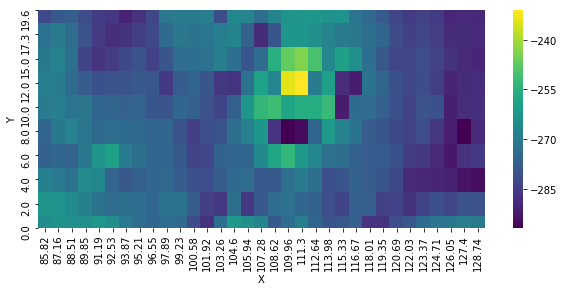

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
#plt.axis('equal')

One of the main disadvantages of the procedure is that only works with complete data sets as show above. Missing data will casue error. I think this is a good case were the package Tetrablocks developed by Dr. Will is going to be handy, specially for obaining the power spectrum of electron density or not so high emission lines (PhD case).

Spectrum Theory

Energy Spectrum
$$E(k) \propto k^{-\beta}$$
Turbulent case
$$\beta = -5 / 3,-2$$
Energy-Power Spectrum relation
$$E(k) \propto k^{N-1} P(k)$$
where it is fullfilled
$$P(k)\propto k^{-\gamma}$$

The next lines show the procedure presented in:
a)https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/?fbclid=IwAR0x6xvMZ11_u6NoOfBWwwfWJrw3KfoHV_Xec51AodNOnMFcueUf5BszL3E and
b)https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59, thought neither of these deals, per se, with the turbuent problem in astrophysical or any other context.

#Recipe: \
1) FFT on the two-dimenional data (Image) \
2) Shifting Frequency components \
NOTE: i) In the case of images, we are dealing with wavenumbers. These procedure has been propose in many contexts, but, it is universal and applies to our problem?  ii) Does the shifting affects the physical spatial distribution or are we losing our separation information? \
3) Calculate the radial average PSD in 1D.
\
\
In the case of 1) and 2) the procedure is straightforward thanks to scipy FFT library. For option 3) we evaluate different procedures: i) Using the ndimage option as suggested in the second link above, ii) doing by "hand" the ndimage stuff, iii) using the codes provide by the first link (radial_data and radialProfile) and iv) using the Turbustat package. A comparison between this options is presented at the end.

#1) 2D Fourier Transform 

In [7]:
#Return multidimensional discrete Fourier transform.
FT2a=scipy.fftpack.fft2(data_2)
power_s0=np.abs(FT2a)

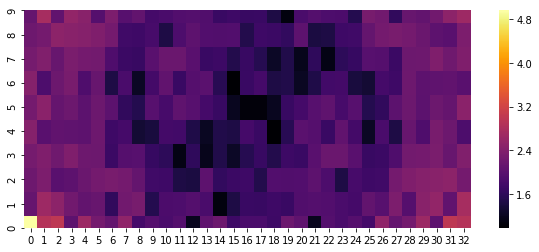

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()
#plt.axis('equal')

#2) Shifting components 

In [9]:
#Shift the zero-frequency component to the center of the spectrum.
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)

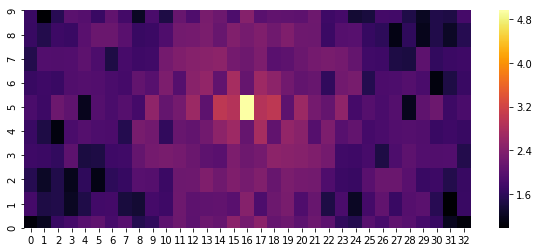

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()
#plt.axis('equal')

Create an array of "rings" parting from the center of the image. 

In [11]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

In [12]:
h,w,wc,hc

(10, 33, 16, 5)

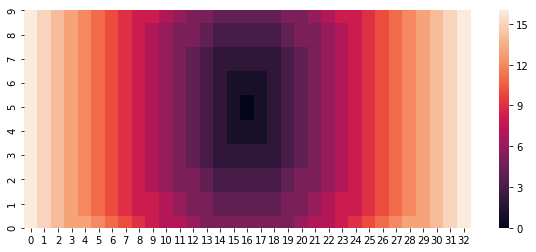

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rdf)
plt.gca().invert_yaxis()
#plt.axis('equal')

NOTE: In these case the data is not very smooth so the idea of perfect "rings" vanish, but the essence of the procudere stills holds.

#Wavenumber

Now we obtain the relation physical scale (L) - wavenumber (k=1/L)

In [14]:
k0=[0*(1) for i in range(wc-1)]
a=1.34125#pixel value obs data
k0[0]=(data.X.max()-data.X.min())/2
for i in range(14):
    k0[i+1]=k0[i]-a
np.array(k0)    


array([21.456  , 20.11475, 18.7735 , 17.43225, 16.091  , 14.74975,
       13.4085 , 12.06725, 10.726  ,  9.38475,  8.0435 ,  6.70225,
        5.361  ,  4.01975,  2.6785 ])

Considering the "ring" distribution above, the last array will show the distance from the center ring (r=1,21.45 arcsec since r = 0 is not consider) and outer ring (r=16, 2.67 arcsec)

In [15]:
k0=np.array(k0)
k=k0**-1
k

array([0.04660701, 0.04971476, 0.05326657, 0.05736494, 0.06214654,
       0.06779776, 0.07457956, 0.08286892, 0.0932314 , 0.10655585,
       0.12432399, 0.14920363, 0.18653236, 0.24877169, 0.37334329])

We have applied the wave number definition k=1/L

Now we proceed to the sum of all data landing at the "same" distance from the center. The command ndimage does all the work.

#3) Radial Average

In [16]:
# SUM all psd2D pixels with label 'r' for 0<=r<=wc
psd1D_sx= ndimage.sum(power_s, r, index=np.arange(0, wc+1))

In [17]:
psd1D_sx[2:17]

array([4825.6521439 , 4089.13884688, 4951.6560172 , 5427.48287182,
       2625.79168573, 2679.5785896 , 1877.77752426, 1186.73794389,
       1542.8536051 , 1410.06073371, 1436.9772572 , 1645.90588453,
       1093.0009225 ,  773.67779786,  951.9044606 ])

In [18]:
psx=[k,psd1D_sx[2:17]]
psd1D_s=pd.DataFrame(psx).T
psd1D_s.columns =['k', 'Pk'] 
psd1D_s.head()

,k,Pk
0,0.046607,4825.652144
1,0.049715,4089.138847
2,0.053267,4951.656017
3,0.057365,5427.482872
4,0.062147,2625.791686


Text(0, 0.5, '$ \\mathrm{P(k)}$')

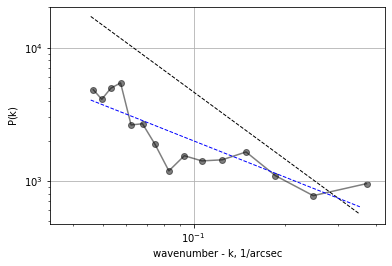

In [19]:
plt.scatter(psd1D_s.k,psd1D_s.Pk,color='k',alpha=0.5 )
plt.loglog(psd1D_s.k,psd1D_s.Pk,color='k',alpha=0.5 )
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**2)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**2.4)*sgrid**(-0.9), color="b", lw=1, label="Power law fit", linestyle='dashed')

plt.grid()
plt.xlabel('wavenumber - k, 1/arcsec')
plt.ylabel(r'$ \mathrm{P(k)}$')

The PSD1 is obtained, as a surprise following these method the Kolmogorov index is a good fit! but the issues mentioned above are still an issue to resolve. 

Now we do, the average of the "rings" (ndiamge.mean instead of sum). \
NOTE: Put literature here

In [20]:
# SUM all psd2D pixels with label 'r' for 0<=r<=wc
psd1D_mx= ndimage.mean(power_s, r, index=np.arange(0, wc+1))
psd1D_mx

array([9.10000100e+04, 4.95941344e+02, 3.01603259e+02, 2.04456942e+02,
       2.06319001e+02, 1.64469178e+02, 1.31289584e+02, 1.21799027e+02,
       7.82407302e+01, 5.93368972e+01, 7.71426803e+01, 7.05030367e+01,
       7.18488629e+01, 7.48139038e+01, 5.46500461e+01, 3.86838899e+01,
       4.75952230e+01])

In [21]:
psd1D_mx[2:17]

array([301.60325899, 204.45694234, 206.31900072, 164.46917793,
       131.28958429, 121.7990268 ,  78.24073018,  59.33689719,
        77.14268026,  70.50303669,  71.84886286,  74.81390384,
        54.65004613,  38.68388989,  47.59522303])

In [22]:
psx=[k,psd1D_mx[2:17]]
psd1D_m=pd.DataFrame(psx).T
psd1D_m.columns =['k', 'Pk'] 
psd1D_m.head()

,k,Pk
0,0.046607,301.603259
1,0.049715,204.456942
2,0.053267,206.319001
3,0.057365,164.469178
4,0.062147,131.289584


Text(0, 0.5, '$ \\mathrm{P(k)}$')

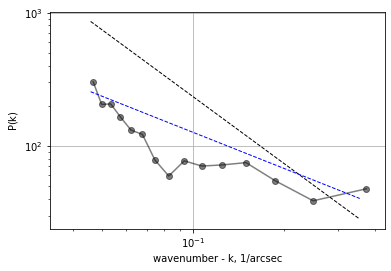

In [23]:
plt.scatter(psd1D_m.k,psd1D_m.Pk,color='k',alpha=0.5 )
plt.loglog(psd1D_m.k,psd1D_m.Pk,color='k',alpha=0.5 )
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**0.7)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**1.2)*sgrid**(-0.9), color="b", lw=1, label="Power law fit", linestyle='dashed')

plt.grid()
plt.xlabel('wavenumber - k, 1/arcsec')
plt.ylabel(r'$ \mathrm{P(k)}$')

Out of the Black-Box method (OBB)

Same as above for ndimage.sum and ndimage.mean but doing all the procedure by "hand" to obtain the error. The same array of rings is used as above.

In [24]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [25]:
for i in range(wc+1):
    m=(rdf==i)
    psm=(psdf[m].fillna(0)).to_numpy()
    s=psm.sum()
    err=psm.std()/np.sqrt(len(psm)-1)
    data_ps[i]=[i,s,err]
    
psd1D_2x=pd.DataFrame(data_ps).T

In [26]:
a=psd1D_2x[1][2:17]
b=psd1D_2x[2][2:17]

In [27]:
psx=[k,a,b]
psd1D_2=pd.DataFrame(psx).T
psd1D_2.columns =['k', 'Pk','Err'] 
psd1D_2.head()

,k,Pk,Err
0,0.046607,4825.652144,29.492494
1,0.049715,4089.138847,17.519286
2,0.053267,4951.656017,20.128097
3,0.057365,5427.482872,17.391959
4,0.062147,2625.791686,11.464256


Computing the difference between ndimage and this method for corroboration.

In [28]:
Err_12=psd1D_s-psd1D_2.Pk
Err_12.sum()

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
Pk    0.0
k     0.0
dtype: float64

[Text(0, 0.5, '$ \\mathrm{P(k)}$'), Text(0.5, 0, 'wavenumber (k), 1/arcsec')]

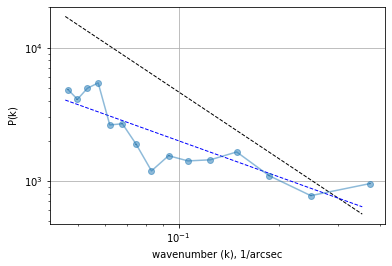

In [29]:
fig, ax=plt.subplots()
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**2)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**2.4)*sgrid**(-0.9), color="b", lw=1, label="Power law fit", linestyle='dashed')
ax.errorbar(psd1D_2.k,psd1D_2.Pk, yerr=psd1D_2.Err, fmt="o-", ecolor='k', alpha=0.5, label="OBB-sum")
ax.set(xscale='log',yscale='log')
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)}$')

Doing now the average...

In [30]:
for i in range(wc+1):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T

In [31]:
a=psd1D_2mx[1][2:17]
b=psd1D_2mx[2][2:17]

In [32]:
psx=[k,a,b]
psd1D_2m=pd.DataFrame(psx).T
psd1D_2m.columns =['k', 'Pk','Err'] 
psd1D_2m.head()

,k,Pk,Err
0,0.046607,261.151336,49.365277
1,0.049715,201.318305,13.245184
2,0.053267,188.795583,13.079725
3,0.057365,180.701296,14.410073
4,0.062147,128.136769,13.931507


[Text(0, 0.5, '$ \\mathrm{P(k)}$'), Text(0.5, 0, 'wavenumber (k), 1/arcsec')]

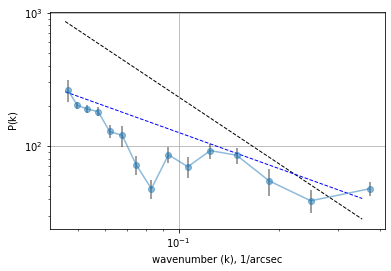

In [33]:
fig, ax=plt.subplots()
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**0.7)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**1.2)*sgrid**(-0.9), color="b", lw=1, label="Power law fit", linestyle='dashed')

ax.errorbar(psd1D_2m.k,psd1D_2m.Pk, yerr=psd1D_2m.Err, fmt="o-", ecolor='k', alpha=0.5)
ax.set(xscale='log',yscale='log')
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)}$')

Implemeneting radialProfile and radial_data for the PSD in 1D, taken from: https://www.astrobetter.com/wiki/tiki-index.php?page=python_image_fft

In [34]:
 psd1D_x1= radialProfile.azimuthalAverage(power_s)
 a=psd1D_x1   

In [35]:
psx=[k,a]
psd1D_x1=pd.DataFrame(psx).T
psd1D_x1.columns =['k', 'Pk'] 
psd1D_x1.head()

,k,Pk
0,0.046607,174.428979
1,0.049715,157.611030
2,0.053267,194.544133
3,0.057365,5089.907160
4,0.062147,171.189944


[Text(0, 0.5, '$ \\mathrm{P(k)}$'), Text(0.5, 0, 'wavenumber (k), 1/arcsec')]

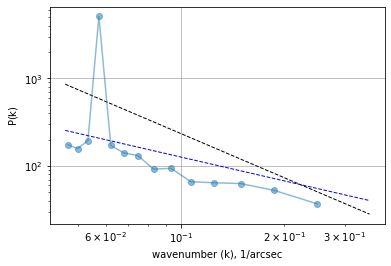

In [36]:
fig, ax=plt.subplots()
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**0.7)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**1.2)*sgrid**(-0.9), color="b", lw=1, label="Power law fit", linestyle='dashed')

ax.errorbar(psd1D_x1.k,psd1D_x1.Pk, fmt="o-", ecolor='k', alpha=0.5)
ax.set(xscale='log',yscale='log')
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)}$')

In the case of radial_data, for some reason the library import doesn't work, so the code is used here.

In [37]:
def radial_data(data,annulus_width=1,working_mask=None,x=None,y=None,rmax=None):
    """
    r = radial_data(data,annulus_width,working_mask,x,y)
    
    A function to reduce an image to a radial cross-section.
    
    INPUT:
    ------
    data   - whatever data you are radially averaging.  Data is
            binned into a series of annuli of width 'annulus_width'
            pixels.
    annulus_width - width of each annulus.  Default is 1.
    working_mask - array of same size as 'data', with zeros at
                      whichever 'data' points you don't want included
                      in the radial data computations.
      x,y - coordinate system in which the data exists (used to set
             the center of the data).  By default, these are set to
             integer meshgrids
      rmax -- maximum radial value over which to compute statistics
    
     OUTPUT:
     -------
      r - a data structure containing the following
                   statistics, computed across each annulus:
          .r      - the radial coordinate used (outer edge of annulus)
          .mean   - mean of the data in the annulus
          .std    - standard deviation of the data in the annulus
          .median - median value in the annulus
          .max    - maximum value in the annulus
          .min    - minimum value in the annulus
          .numel  - number of elements in the annulus
    """
    
# 2010-03-10 19:22 IJC: Ported to python from Matlab
# 2005/12/19 Added 'working_region' option (IJC)
# 2005/12/15 Switched order of outputs (IJC)
# 2005/12/12 IJC: Removed decifact, changed name, wrote comments.
# 2005/11/04 by Ian Crossfield at the Jet Propulsion Laboratory
 
    import numpy as ny

    class radialDat:
        """Empty object container.
        """
        def __init__(self): 
            self.mean = None
            self.std = None
            self.median = None
            self.numel = None
            self.max = None
            self.min = None
            self.r = None

    #---------------------
    # Set up input parameters
    #---------------------
    data = ny.array(data)
    
    if working_mask==None:
        working_mask = ny.ones(data.shape,bool)
    
    npix, npiy = data.shape
    if x==None or y==None:
        x1 = ny.arange(-npix/2.,npix/2.)
        y1 = ny.arange(-npiy/2.,npiy/2.)
        x,y = ny.meshgrid(y1,x1)

    r = abs(x+1j*y)

    if rmax==None:
        rmax = r[working_mask].max()

    #---------------------
    # Prepare the data container
    #---------------------
    dr = ny.abs([x[0,0] - x[0,1]]) * annulus_width
    radial = ny.arange(rmax/dr)*dr + dr/2.
    nrad = len(radial)
    radialdata = radialDat()
    radialdata.mean = ny.zeros(nrad)
    radialdata.std = ny.zeros(nrad)
    radialdata.median = ny.zeros(nrad)
    radialdata.numel = ny.zeros(nrad)
    radialdata.max = ny.zeros(nrad)
    radialdata.min = ny.zeros(nrad)
    radialdata.r = radial
    
    #---------------------
    # Loop through the bins
    #---------------------
    for irad in range(nrad): #= 1:numel(radial)
      minrad = irad*dr
      maxrad = minrad + dr
      thisindex = (r>=minrad) * (r<maxrad) * working_mask
      if not thisindex.ravel().any():
        radialdata.mean[irad] = ny.nan
        radialdata.std[irad]  = ny.nan
        radialdata.median[irad] = ny.nan
        radialdata.numel[irad] = ny.nan
        radialdata.max[irad] = ny.nan
        radialdata.min[irad] = ny.nan
      else:
        radialdata.mean[irad] = data[thisindex].mean()
        radialdata.std[irad]  = data[thisindex].std()
        radialdata.median[irad] = ny.median(data[thisindex])
        radialdata.numel[irad] = data[thisindex].size
        radialdata.max[irad] = data[thisindex].max()
        radialdata.min[irad] = data[thisindex].min()
    
    #---------------------
    # Return with data
    #---------------------
    
    return radialdata

In [38]:
psd1D_x2=radial_data(power_s)

In [39]:
psd1D_x2.mean

array([4.59006802e+04, 4.59354263e+02, 2.59280129e+02, 2.17063223e+02,
       1.84613682e+02, 1.67625249e+02, 1.33716167e+02, 1.09238837e+02,
       7.56935276e+01, 6.12302430e+01, 7.27626605e+01, 7.41323111e+01,
       7.33681832e+01, 6.89584085e+01, 5.31666786e+01, 4.25082332e+01,
       4.31594414e+01, 1.15298579e+01])

In [40]:
a=psd1D_x2.mean[3:18]

In [41]:
psx=[k,a]
psd1D_x2=pd.DataFrame(psx).T
psd1D_x2.columns =['k', 'Pk'] 
psd1D_x2.head()

,k,Pk
0,0.046607,217.063223
1,0.049715,184.613682
2,0.053267,167.625249
3,0.057365,133.716167
4,0.062147,109.238837


[Text(0, 0.5, '$ \\mathrm{P(k)}$'), Text(0.5, 0, 'wavenumber (k), 1/arcsec')]

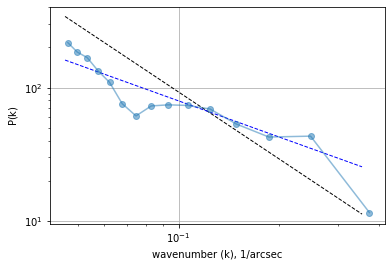

In [42]:
fig, ax=plt.subplots()
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**0.3)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**1.0)*sgrid**(-0.9), color="b", lw=1, label="Power law fit", linestyle='dashed')

ax.errorbar(psd1D_x2.k,psd1D_x2.Pk, fmt="o-", ecolor='k', alpha=0.5)
ax.set(xscale='log',yscale='log')
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)}$')

The values below were obtaied with the the Turbustat code, using the radial velocty map. \
from turbustat.statistics import PowerSpectrum

In [43]:
TS=[148536.11369865,  82717.41336635,  45850.75929248,  15111.00265915,
        38361.31818442,  71282.00632571,  32228.69163749,  27635.93777926,
        10588.51842271,  28300.66687279,  18535.35958634,   3976.58132317,
         5891.33242062,  18845.06306528,  13757.14931646,   5622.48329691,
         3167.61986153,   4839.82875265]

In [44]:
a=TS[3:18]

In [45]:
psx=[k,a]
psd1D_ts=pd.DataFrame(psx).T
psd1D_ts.columns =['k', 'Pk'] 
psd1D_ts.head()

,k,Pk
0,0.046607,15111.002659
1,0.049715,38361.318184
2,0.053267,71282.006326
3,0.057365,32228.691637
4,0.062147,27635.937779


[Text(0, 0.5, '$ \\mathrm{P(k)}$'), Text(0.5, 0, 'wavenumber (k), 1/arcsec')]

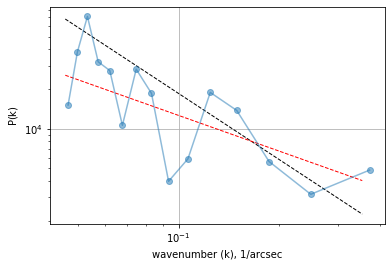

In [46]:
fig, ax=plt.subplots()
sgrid = np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**2.6)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov", linestyle='dashed')
plt.plot(sgrid, (10**3.2)*sgrid**(-0.9), color="r", lw=1, label="Power law fit", linestyle='dashed')

ax.errorbar(psd1D_ts.k,psd1D_ts.Pk, fmt="o-", ecolor='k', alpha=0.5)
ax.set(xscale='log',yscale='log')
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)}$')

A comparison between methods would give more insight of the behaviour between them.

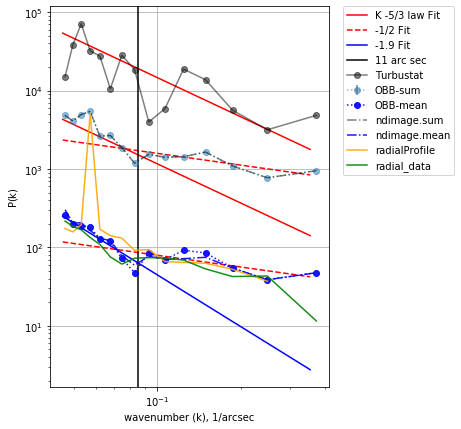

In [47]:
fig, ax = plt.subplots(figsize=(5, 7))
ax.errorbar(psd1D_ts.k,psd1D_ts.Pk, fmt="o-", color="black", alpha=0.5, label="Turbustat")
ax.errorbar(psd1D_2.k,psd1D_2.Pk, yerr=psd1D_2.Err, fmt="o:", ecolor='k', alpha=0.5, label="OBB-sum")
ax.errorbar(psd1D_2m.k,psd1D_2m.Pk, fmt="o:", color='b', alpha=0.9, label="OBB-mean")
ax.errorbar(psd1D_s.k,psd1D_s.Pk, fmt="-.", color='k', alpha=0.5, label="ndimage.sum")
ax.errorbar(psd1D_m.k,psd1D_m.Pk, fmt="-.", color='b', alpha=0.9, label="ndimage.mean")
ax.errorbar(psd1D_x1.k,psd1D_x1.Pk, color="orange", alpha=0.9, label="radialProfile")
ax.errorbar(psd1D_x2.k,psd1D_x2.Pk, color="green", alpha=0.9, label="radial_data")

sgrid= np.logspace(-1.34, -0.45)
plt.plot(sgrid, (10**2.5)*sgrid**(-5/3), color="red", label="K -5/3 law Fit")
plt.plot(sgrid, (10**2.7)*sgrid**(-0.5), color="red",linestyle='--', label="-1/2 Fit")
plt.plot(sgrid, (10**1.4)*sgrid**(-5/3), color="red" )
plt.plot(sgrid, (10**-.55)*sgrid**(-2.2), color="blue",label="-1.9 Fit" )
plt.plot(sgrid, (10**1.4)*sgrid**(-0.5), color="red",linestyle='--')

ax.axvline(x=0.085, color='k', linestyle='-', label="11 arc sec")

ax.set(xscale='log',yscale='log')
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)}$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


We can see that the OBB (dotted line) and ndimage (dashed point line) practically gave the same results for sum (black) and mean (blue), not a surprise. The radialProfile (solid orange) and radial_data (solid green) also correspond to a similar behaviour as the mean procedure (probably because they do essentially the same thing), except for a weird peak in the radialProfile. The turbustat package shows the gratest difference of all, but also a similar behaviour. Also the turbustat option gives a different range of values. The Kolmogorov fit do not apply precisley but it is shown as a first approach to study the problem and compare. Also we can see different power law fits can be made following different criteria. 

As conclusion for the comparison, we see that we have many methods to do the same thing with a good degree of coincidence, except for the values of P(k). One idea to resolve this issue is to relate (if possible) the energy in th velocity to a p(k) value.